# Analisa Perubahan Iklim terhadap Produksi Padi di Jawa Barat tahun 2010 - 2022

#### Analisa dilakukan dengan menggunakan temperatur rata-rata, temperatur minimum, temperatur maksimum, total curah hujan, dan rata-rata kelembaban udara harian tahun 2010 - 2022.
#### Data ini diambil di  Stasiun Klimatologi Jawa Barat, dengan Lintang:  -6.50000 dan Bujur:  106.75000
#### Data produksi padi diambil di BPS Provinsi Jawa Barat tahun 2010 - 2022 menurut  Kabupaten/Kota (Ton)

## Menyiapkan library dan Dataset

In [1]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install openpyxl

In [146]:
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql import SparkSession, dataframe
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, FloatType, DateType
from pyspark.sql.functions import split, count, when, isnan, col, regexp_replace,asc, desc, avg, min, max, mean, year, explode
from pyspark.sql import functions as F
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import OneHotEncoder, StringIndexer, MinMaxScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [55]:
spark = SparkSession.builder.appName("Analisis Dampak Peningkatan Suhu Terhadap Produktivitas Padi").getOrCreate()

print('Spark Version: {}'.format(spark.version))

Spark Version: 3.5.0


In [56]:
suhu_df = pd.read_excel('suhu_data.xlsx', sheet_name='dataharian')

In [84]:
lst=[]
for i in suhu_df.index:
    data = {}
    data['tgl'] = suhu_df['tgl'][i]
    data['tmin'] = suhu_df['tmin'][i]
    data['tmaks'] = suhu_df['tmaks'][i]
    data['tavg'] = suhu_df['tavg'][i]
    lst.append(data)
print(lst)

[{'tgl': '01-01-2010', 'tmin': 23.0, 'tmaks': 31.6, 'tavg': 26.4}, {'tgl': '02-01-2010', 'tmin': 24.0, 'tmaks': 32.8, 'tavg': 26.5}, {'tgl': '03-01-2010', 'tmin': 24.0, 'tmaks': 31.3, 'tavg': 27.0}, {'tgl': '04-01-2010', 'tmin': 24.0, 'tmaks': 31.9, 'tavg': 26.6}, {'tgl': '05-01-2010', 'tmin': 24.0, 'tmaks': 32.6, 'tavg': 26.0}, {'tgl': '06-01-2010', 'tmin': 23.0, 'tmaks': 31.6, 'tavg': 25.9}, {'tgl': '07-01-2010', 'tmin': 23.0, 'tmaks': 32.2, 'tavg': 25.5}, {'tgl': '08-01-2010', 'tmin': 22.0, 'tmaks': 29.7, 'tavg': 24.7}, {'tgl': '09-01-2010', 'tmin': 23.0, 'tmaks': 29.4, 'tavg': 25.0}, {'tgl': '10-01-2010', 'tmin': 22.0, 'tmaks': 28.4, 'tavg': 25.1}, {'tgl': '11-01-2010', 'tmin': 23.0, 'tmaks': 32.1, 'tavg': 26.0}, {'tgl': '12-01-2010', 'tmin': 23.0, 'tmaks': 28.7, 'tavg': 25.2}, {'tgl': '13-01-2010', 'tmin': 23.0, 'tmaks': 27.2, 'tavg': 24.4}, {'tgl': '14-01-2010', 'tmin': 22.0, 'tmaks': 28.2, 'tavg': 23.1}, {'tgl': '15-01-2010', 'tmin': 22.0, 'tmaks': 28.2, 'tavg': 24.1}, {'tgl': '

In [86]:
suhu_df.to_csv("suhu.csv", index=False)

In [88]:
curah_hujan_df = pd.read_excel('curah_hujan_data.xlsx', sheet_name='dataharian')
kelembaban_df = pd.read_excel('kelembaban_data.xlsx', sheet_name='dataharian')

In [89]:
lst=[]
for i in curah_hujan_df.index:
    data = {}
    data['tgl'] = curah_hujan_df['tgl'][i]
    data['rr'] = curah_hujan_df['rr'][i]
    lst.append(data)
print(lst)

[{'tgl': '01-01-2010', 'rr': 0.5}, {'tgl': '02-01-2010', 'rr': 8888.0}, {'tgl': '03-01-2010', 'rr': 2.8}, {'tgl': '04-01-2010', 'rr': 0.0}, {'tgl': '05-01-2010', 'rr': 0.2}, {'tgl': '06-01-2010', 'rr': 3.8}, {'tgl': '07-01-2010', 'rr': 3.0}, {'tgl': '08-01-2010', 'rr': 10.2}, {'tgl': '09-01-2010', 'rr': 0.7}, {'tgl': '10-01-2010', 'rr': 48.6}, {'tgl': '11-01-2010', 'rr': 7.2}, {'tgl': '12-01-2010', 'rr': 13.3}, {'tgl': '13-01-2010', 'rr': 7.0}, {'tgl': '14-01-2010', 'rr': 13.4}, {'tgl': '15-01-2010', 'rr': 48.0}, {'tgl': '16-01-2010', 'rr': 3.0}, {'tgl': '17-01-2010', 'rr': 2.6}, {'tgl': '18-01-2010', 'rr': 21.6}, {'tgl': '19-01-2010', 'rr': 2.5}, {'tgl': '20-01-2010', 'rr': 2.9}, {'tgl': '21-01-2010', 'rr': 3.8}, {'tgl': '22-01-2010', 'rr': 1.2}, {'tgl': '23-01-2010', 'rr': 4.6}, {'tgl': '24-01-2010', 'rr': 11.0}, {'tgl': '25-01-2010', 'rr': 13.5}, {'tgl': '26-01-2010', 'rr': 1.1}, {'tgl': '27-01-2010', 'rr': 0.0}, {'tgl': '28-01-2010', 'rr': 8.5}, {'tgl': '29-01-2010', 'rr': 5.8}, {'

In [90]:
lst=[]
for i in kelembaban_df.index:
    data = {}
    data['tgl'] = kelembaban_df['tgl'][i]
    data['rh_avg'] = kelembaban_df['rh_avg'][i]
    lst.append(data)
print(lst)

[{'tgl': '01-01-2010', 'rh_avg': 82.0}, {'tgl': '02-01-2010', 'rh_avg': 84.0}, {'tgl': '03-01-2010', 'rh_avg': 85.0}, {'tgl': '04-01-2010', 'rh_avg': 83.0}, {'tgl': '05-01-2010', 'rh_avg': 84.0}, {'tgl': '06-01-2010', 'rh_avg': 85.0}, {'tgl': '07-01-2010', 'rh_avg': 87.0}, {'tgl': '08-01-2010', 'rh_avg': 88.0}, {'tgl': '09-01-2010', 'rh_avg': 90.0}, {'tgl': '10-01-2010', 'rh_avg': 89.0}, {'tgl': '11-01-2010', 'rh_avg': 84.0}, {'tgl': '12-01-2010', 'rh_avg': 85.0}, {'tgl': '13-01-2010', 'rh_avg': 90.0}, {'tgl': '14-01-2010', 'rh_avg': 95.0}, {'tgl': '15-01-2010', 'rh_avg': 90.0}, {'tgl': '16-01-2010', 'rh_avg': 92.0}, {'tgl': '17-01-2010', 'rh_avg': 92.0}, {'tgl': '18-01-2010', 'rh_avg': 79.0}, {'tgl': '19-01-2010', 'rh_avg': 90.0}, {'tgl': '20-01-2010', 'rh_avg': 92.0}, {'tgl': '21-01-2010', 'rh_avg': 85.0}, {'tgl': '22-01-2010', 'rh_avg': 96.0}, {'tgl': '23-01-2010', 'rh_avg': 88.0}, {'tgl': '24-01-2010', 'rh_avg': 88.0}, {'tgl': '25-01-2010', 'rh_avg': 87.0}, {'tgl': '26-01-2010', 'r

In [92]:
curah_hujan_df.to_csv("curah_hujan.csv", index=False)
kelembaban_df.to_csv("kelembaban.csv", index=False)

In [147]:
produksi_padi_df = pd.read_excel('produksi_padi_data.xlsx', sheet_name='Sheet1')

In [150]:
lst=[]
for i in produksi_padi_df.index:
    data = {}
    data['periode'] = produksi_padi_df['periode'][i]
    data['Provinsi Jawa Barat'] = produksi_padi_df['Provinsi Jawa Barat'][i]
    data['Bogor'] = produksi_padi_df['Bogor'][i]
    data['Sukabumi'] = produksi_padi_df['Sukabumi'][i]
    data['Cianjur'] = produksi_padi_df['Cianjur'][i]
    data['Bandung'] = produksi_padi_df['Bandung'][i]
    data['Garut'] = produksi_padi_df['Garut'][i]
    data['Tasikmalaya'] = produksi_padi_df['Tasikmalaya'][i]
    data['Ciamis'] = produksi_padi_df['Ciamis'][i]
    data['Kuningan'] = produksi_padi_df['Kuningan'][i]
    data['Cirebon'] = produksi_padi_df['Cirebon'][i]
    data['Majalegka'] = produksi_padi_df['Majalengka'][i]
    data['Sumedang'] = produksi_padi_df['Sumedang'][i]
    data['Indramayu'] = produksi_padi_df['Indramayu'][i]
    data['Subang'] = produksi_padi_df['Subang'][i]
    data['Purwakarta'] = produksi_padi_df['Purwakarta'][i]
    data['Karawang'] = produksi_padi_df['Karawang'][i]
    data['Bekasi'] = produksi_padi_df['Bekasi'][i]
    data['Bandung Barat'] = produksi_padi_df['Bandung Barat'][i]
    data['Pangandaran'] = produksi_padi_df['Pangandaran'][i]
    data['Kota Bogor'] = produksi_padi_df['Kota Bogor'][i]
    data['Kota Sukabumi'] = produksi_padi_df['Kota Sukabumi'][i]
    data['Kota Bandung'] = produksi_padi_df['Kota Bandung'][i]
    data['Kota Cirebon'] = produksi_padi_df['Kota Cirebon'][i]
    data['Kota Bekasi'] = produksi_padi_df['Kota Bekasi'][i]
    data['Kota Depok'] = produksi_padi_df['Kota Depok'][i]
    data['Kota Cimahi'] = produksi_padi_df['Kota Cimahi'][i]
    data['Kota Tasikmalaya'] = produksi_padi_df['Kota Tasikmalaya'][i]
    data['Kota Banjar'] = produksi_padi_df['Kota Banjar'][i]

    
    
    
    
    lst.append(data)
print(lst)

[{'periode': 2010, 'Provinsi Jawa Barat': 11737071.0, 'Bogor': 538804.0, 'Sukabumi': 805924.0, 'Cianjur': 862229.0, 'Bandung': 459077.0, 'Garut': 894197.0, 'Tasikmalaya': 851108.0, 'Ciamis': 724842.0, 'Kuningan': 374925.0, 'Cirebon': 510419.0, 'Majalegka': 580638.0, 'Sumedang': 453303.0, 'Indramayu': 1358441.0, 'Subang': 919789.0, 'Purwakarta': 238876.0, 'Karawang': 1113978.0, 'Bekasi': 590043.0, 'Bandung Barat': 267347.0, 'Pangandaran': '-', 'Kota Bogor': 8331.0, 'Kota Sukabumi': 21682.0, 'Kota Bandung': 8177.0, 'Kota Cirebon': 4300.0, 'Kota Bekasi': 5708.0, 'Kota Depok': 4828.0, 'Kota Cimahi': 3806.0, 'Kota Tasikmalaya': 88411.0, 'Kota Banjar': 47888.0}, {'periode': 2011, 'Provinsi Jawa Barat': 11633891.0, 'Bogor': 497711.0, 'Sukabumi': 724025.0, 'Cianjur': 790824.0, 'Bandung': 464425.0, 'Garut': 907011.0, 'Tasikmalaya': 808908.0, 'Ciamis': 684837.0, 'Kuningan': 383968.0, 'Cirebon': 522965.0, 'Majalegka': 586691.0, 'Sumedang': 460212.0, 'Indramayu': 1415050.0, 'Subang': 1059905.0, 'P

In [151]:
produksi_padi_df.to_csv("produksi_padi.csv", index=False)

### Preprocessing Data

In [57]:
suhu = pd.read_csv("suhu.csv")
print(suhu)

             tgl  tmin  tmaks  tavg
0     01-01-2010  23.0   31.6  26.4
1     02-01-2010  24.0   32.8  26.5
2     03-01-2010  24.0   31.3  27.0
3     04-01-2010  24.0   31.9  26.6
4     05-01-2010  24.0   32.6  26.0
...          ...   ...    ...   ...
4743  27-12-2022  20.8   27.9  24.7
4744  28-12-2022  20.2   27.6  23.4
4745  29-12-2022  20.8   27.2  24.0
4746  30-12-2022  21.0   27.2  24.4
4747  31-12-2022  21.8   27.1  24.3

[4748 rows x 4 columns]


In [58]:
curah_hujan = pd.read_csv("curah_hujan.csv")
print(curah_hujan)

             tgl      rr
0     01-01-2010     0.5
1     02-01-2010  8888.0
2     03-01-2010     2.8
3     04-01-2010     0.0
4     05-01-2010     0.2
...          ...     ...
4743  27-12-2022    22.9
4744  28-12-2022     3.0
4745  29-12-2022    26.2
4746  30-12-2022    18.7
4747  31-12-2022     1.5

[4748 rows x 2 columns]


In [59]:
kelembaban = pd.read_csv("kelembaban.csv")
print(kelembaban)

             tgl  rh_avg
0     01-01-2010    82.0
1     02-01-2010    84.0
2     03-01-2010    85.0
3     04-01-2010    83.0
4     05-01-2010    84.0
...          ...     ...
4743  27-12-2022    85.0
4744  28-12-2022    92.0
4745  29-12-2022    92.0
4746  30-12-2022    92.0
4747  31-12-2022    92.0

[4748 rows x 2 columns]


In [60]:
produksi_padi = pd.read_csv("produksi_padi.csv")
print(produksi_padi)

    periode  Provinsi Jawa Barat      Bogor   Sukabumi    Cianjur    Bandung  \
0      2010          11737071.00  538804.00  805924.00  862229.00  459077.00   
1      2011          11633891.00  497711.00  724025.00  790824.00  464425.00   
2      2012          11271861.00  494815.00  825788.00  868538.00  479425.00   
3      2013          12083162.00  559367.00  767668.00  882662.00  584335.00   
4      2014          11644899.00  517442.00  897485.00  830545.00  462977.00   
5      2015          11373143.00  492207.00  842655.00  851650.00  483315.00   
6      2016          12540550.00  582917.00  956502.00  939731.00  518331.00   
7      2017          12299701.00  562644.00  901902.00  874393.00  590827.00   
8      2018           9647359.00  348683.60  525859.00  696726.00  314869.20   
9      2019           9084957.00  307860.90  468764.30  641804.30  344214.40   
10     2020           9016772.58  298974.65  521459.25  622992.32  277156.28   
11     2021           9113573.00  285154

In [61]:
suhu.isna().sum()

tgl        0
tmin     327
tmaks    258
tavg     201
dtype: int64

In [62]:
rata_suhu = suhu['tmin'].mean()

In [63]:
suhu['tmin'] = suhu['tmin'].fillna(rata_suhu)

In [64]:
rata_suhu = suhu['tmaks'].mean()

In [65]:
suhu['tmaks'] = suhu['tmaks'].fillna(rata_suhu)

In [66]:
rata_suhu = suhu['tavg'].mean()

In [67]:
suhu['tavg'] = suhu['tavg'].fillna(rata_suhu)

In [68]:
suhu.isna().sum()

tgl      0
tmin     0
tmaks    0
tavg     0
dtype: int64

In [69]:
curah_hujan.isna().sum()

tgl       0
rr     1024
dtype: int64

In [70]:
rata_ch = curah_hujan['rr'].mean()

In [71]:
curah_hujan['rr'] = curah_hujan['rr'].fillna(rata_ch)

In [72]:
curah_hujan.isna().sum()

tgl    0
rr     0
dtype: int64

In [73]:
kelembaban.isna().sum()

tgl         0
rh_avg    203
dtype: int64

In [74]:
avg_lembab = kelembaban['rh_avg'].mean()

In [75]:
kelembaban['rh_avg'] = kelembaban['rh_avg'].fillna(avg_lembab)

In [76]:
kelembaban.isna().sum()

tgl       0
rh_avg    0
dtype: int64

In [77]:
produksi_padi.isna().sum()

periode                0
Provinsi Jawa Barat    0
Bogor                  0
Sukabumi               0
Cianjur                0
Bandung                0
Garut                  0
Tasikmalaya            0
Ciamis                 0
Kuningan               0
Cirebon                0
Majalengka             0
Sumedang               0
Indramayu              0
Subang                 0
Purwakarta             0
Karawang               0
Bekasi                 0
Bandung Barat          0
Pangandaran            0
Kota Bogor             0
Kota Sukabumi          0
Kota Bandung           0
Kota Cirebon           0
Kota Bekasi            0
Kota Depok             0
Kota Cimahi            0
Kota Tasikmalaya       0
Kota Banjar            0
dtype: int64

In [78]:
#Defining a Schema
schema = StructType([StructField('wilayah', IntegerType(), nullable = True),
                     StructField('2023', IntegerType(), nullable = True),
                     StructField('2022', IntegerType(), nullable = True),
                     StructField('2021', IntegerType(), nullable = True),
                     StructField('2020', IntegerType(), nullable = True),
                     StructField('2019', IntegerType(), nullable = True),
                     StructField('2018', IntegerType(), nullable = True),
                     StructField('2017', IntegerType(), nullable = True),
                     StructField('2016', IntegerType(), nullable = True),
                     StructField('2015', IntegerType(), nullable = True),
                     StructField('2014', IntegerType(), nullable = True),
                     StructField('2013', IntegerType(), nullable = True),
                     StructField('2012', IntegerType(), nullable = True),
                     StructField('2011', IntegerType(), nullable = True),
                     StructField('2010', IntegerType(), nullable = True)])


file_path = 'C:/Users/Nadya Arassy/Downloads/ds_dataset/produksi_padi.csv'


produksi_padi_df = spark.read.csv(file_path,
                    header = True,
                    inferSchema = True,
                    nanValue = '?')

produksi_padi_df.show(15)

+-------+-------------------+---------+---------+---------+---------+--------+-----------+---------+---------+---------+----------+--------+----------+----------+----------+----------+---------+-------------+-----------+----------+-------------+------------+------------+-----------+----------+-----------+----------------+-----------+
|periode|Provinsi Jawa Barat|    Bogor| Sukabumi|  Cianjur|  Bandung|   Garut|Tasikmalaya|   Ciamis| Kuningan|  Cirebon|Majalengka|Sumedang| Indramayu|    Subang|Purwakarta|  Karawang|   Bekasi|Bandung Barat|Pangandaran|Kota Bogor|Kota Sukabumi|Kota Bandung|Kota Cirebon|Kota Bekasi|Kota Depok|Kota Cimahi|Kota Tasikmalaya|Kota Banjar|
+-------+-------------------+---------+---------+---------+---------+--------+-----------+---------+---------+---------+----------+--------+----------+----------+----------+----------+---------+-------------+-----------+----------+-------------+------------+------------+-----------+----------+-----------+----------------+-----

In [79]:
#Defining a Schema
schema = StructType([StructField('tgl', IntegerType(), nullable = True),
                     StructField('tmin', IntegerType(), nullable = True),
                     StructField('tmaks', IntegerType(), nullable = True),
                     StructField('tavg', IntegerType(), nullable = True)])


file_path = 'C:/Users/Nadya Arassy/Downloads/ds_dataset/suhu.csv'


suhu_df = spark.read.csv(file_path,
                    header = True,
                    inferSchema = True,
                    nanValue = '?')

suhu_df.show(15)

+----------+----+-----+----+
|       tgl|tmin|tmaks|tavg|
+----------+----+-----+----+
|01-01-2010|23.0| 31.6|26.4|
|02-01-2010|24.0| 32.8|26.5|
|03-01-2010|24.0| 31.3|27.0|
|04-01-2010|24.0| 31.9|26.6|
|05-01-2010|24.0| 32.6|26.0|
|06-01-2010|23.0| 31.6|25.9|
|07-01-2010|23.0| 32.2|25.5|
|08-01-2010|22.0| 29.7|24.7|
|09-01-2010|23.0| 29.4|25.0|
|10-01-2010|22.0| 28.4|25.1|
|11-01-2010|23.0| 32.1|26.0|
|12-01-2010|23.0| 28.7|25.2|
|13-01-2010|23.0| 27.2|24.4|
|14-01-2010|22.0| 28.2|23.1|
|15-01-2010|22.0| 28.2|24.1|
+----------+----+-----+----+
only showing top 15 rows



In [80]:
#Defining a Schema
schema = StructType([StructField('tgl', IntegerType(), nullable = True),
                     StructField('rr', IntegerType(), nullable = True)])


file_path = 'C:/Users/Nadya Arassy/Downloads/ds_dataset/curah_hujan.csv'


curah_hujan_df = spark.read.csv(file_path,
                    header = True,
                    inferSchema = True,
                    nanValue = '?')

curah_hujan_df.show(15)

+----------+------+
|       tgl|    rr|
+----------+------+
|01-01-2010|   0.5|
|02-01-2010|8888.0|
|03-01-2010|   2.8|
|04-01-2010|   0.0|
|05-01-2010|   0.2|
|06-01-2010|   3.8|
|07-01-2010|   3.0|
|08-01-2010|  10.2|
|09-01-2010|   0.7|
|10-01-2010|  48.6|
|11-01-2010|   7.2|
|12-01-2010|  13.3|
|13-01-2010|   7.0|
|14-01-2010|  13.4|
|15-01-2010|  48.0|
+----------+------+
only showing top 15 rows



In [81]:
#Defining a Schema
schema = StructType([StructField('tgl', IntegerType(), nullable = True),
                     StructField('rh_avg', IntegerType(), nullable = True)])


file_path = 'C:/Users/Nadya Arassy/Downloads/ds_dataset/kelembaban.csv'


kelembaban_df = spark.read.csv(file_path,
                    header = True,
                    inferSchema = True,
                    nanValue = '?')

kelembaban_df.show(15)

+----------+------+
|       tgl|rh_avg|
+----------+------+
|01-01-2010|  82.0|
|02-01-2010|  84.0|
|03-01-2010|  85.0|
|04-01-2010|  83.0|
|05-01-2010|  84.0|
|06-01-2010|  85.0|
|07-01-2010|  87.0|
|08-01-2010|  88.0|
|09-01-2010|  90.0|
|10-01-2010|  89.0|
|11-01-2010|  84.0|
|12-01-2010|  85.0|
|13-01-2010|  90.0|
|14-01-2010|  95.0|
|15-01-2010|  90.0|
+----------+------+
only showing top 15 rows



In [82]:
suhu_df.printSchema()

root
 |-- tgl: string (nullable = true)
 |-- tmin: double (nullable = true)
 |-- tmaks: double (nullable = true)
 |-- tavg: double (nullable = true)



#### Membuat kolom tanggal baru

In [83]:
from pyspark.sql import functions as F

#convert 'ts' column from string to timestamp
suhu_df = suhu_df.withColumn('date_new', F.to_date('tgl', 'dd-MM-yyyy'))

#view updated DataFrame 
suhu_df.show()


+----------+----+-----+----+----------+
|       tgl|tmin|tmaks|tavg|  date_new|
+----------+----+-----+----+----------+
|01-01-2010|23.0| 31.6|26.4|2010-01-01|
|02-01-2010|24.0| 32.8|26.5|2010-01-02|
|03-01-2010|24.0| 31.3|27.0|2010-01-03|
|04-01-2010|24.0| 31.9|26.6|2010-01-04|
|05-01-2010|24.0| 32.6|26.0|2010-01-05|
|06-01-2010|23.0| 31.6|25.9|2010-01-06|
|07-01-2010|23.0| 32.2|25.5|2010-01-07|
|08-01-2010|22.0| 29.7|24.7|2010-01-08|
|09-01-2010|23.0| 29.4|25.0|2010-01-09|
|10-01-2010|22.0| 28.4|25.1|2010-01-10|
|11-01-2010|23.0| 32.1|26.0|2010-01-11|
|12-01-2010|23.0| 28.7|25.2|2010-01-12|
|13-01-2010|23.0| 27.2|24.4|2010-01-13|
|14-01-2010|22.0| 28.2|23.1|2010-01-14|
|15-01-2010|22.0| 28.2|24.1|2010-01-15|
|16-01-2010|23.0| 26.6|24.3|2010-01-16|
|17-01-2010|23.0| 27.6|24.2|2010-01-17|
|18-01-2010|23.0| 31.1|26.1|2010-01-18|
|19-01-2010|23.0| 29.8|25.3|2010-01-19|
|20-01-2010|22.0| 28.3|23.9|2010-01-20|
+----------+----+-----+----+----------+
only showing top 20 rows



In [84]:
# Drop the 'ts_new' column
suhu_df = suhu_df.drop('ts_new')

# View the updated DataFrame
suhu_df.show()


+----------+----+-----+----+----------+
|       tgl|tmin|tmaks|tavg|  date_new|
+----------+----+-----+----+----------+
|01-01-2010|23.0| 31.6|26.4|2010-01-01|
|02-01-2010|24.0| 32.8|26.5|2010-01-02|
|03-01-2010|24.0| 31.3|27.0|2010-01-03|
|04-01-2010|24.0| 31.9|26.6|2010-01-04|
|05-01-2010|24.0| 32.6|26.0|2010-01-05|
|06-01-2010|23.0| 31.6|25.9|2010-01-06|
|07-01-2010|23.0| 32.2|25.5|2010-01-07|
|08-01-2010|22.0| 29.7|24.7|2010-01-08|
|09-01-2010|23.0| 29.4|25.0|2010-01-09|
|10-01-2010|22.0| 28.4|25.1|2010-01-10|
|11-01-2010|23.0| 32.1|26.0|2010-01-11|
|12-01-2010|23.0| 28.7|25.2|2010-01-12|
|13-01-2010|23.0| 27.2|24.4|2010-01-13|
|14-01-2010|22.0| 28.2|23.1|2010-01-14|
|15-01-2010|22.0| 28.2|24.1|2010-01-15|
|16-01-2010|23.0| 26.6|24.3|2010-01-16|
|17-01-2010|23.0| 27.6|24.2|2010-01-17|
|18-01-2010|23.0| 31.1|26.1|2010-01-18|
|19-01-2010|23.0| 29.8|25.3|2010-01-19|
|20-01-2010|22.0| 28.3|23.9|2010-01-20|
+----------+----+-----+----+----------+
only showing top 20 rows



In [85]:
# Drop the 'tgl' column
suhu_df = suhu_df.drop('tgl')

# View the updated DataFrame
suhu_df.show()


+----+-----+----+----------+
|tmin|tmaks|tavg|  date_new|
+----+-----+----+----------+
|23.0| 31.6|26.4|2010-01-01|
|24.0| 32.8|26.5|2010-01-02|
|24.0| 31.3|27.0|2010-01-03|
|24.0| 31.9|26.6|2010-01-04|
|24.0| 32.6|26.0|2010-01-05|
|23.0| 31.6|25.9|2010-01-06|
|23.0| 32.2|25.5|2010-01-07|
|22.0| 29.7|24.7|2010-01-08|
|23.0| 29.4|25.0|2010-01-09|
|22.0| 28.4|25.1|2010-01-10|
|23.0| 32.1|26.0|2010-01-11|
|23.0| 28.7|25.2|2010-01-12|
|23.0| 27.2|24.4|2010-01-13|
|22.0| 28.2|23.1|2010-01-14|
|22.0| 28.2|24.1|2010-01-15|
|23.0| 26.6|24.3|2010-01-16|
|23.0| 27.6|24.2|2010-01-17|
|23.0| 31.1|26.1|2010-01-18|
|23.0| 29.8|25.3|2010-01-19|
|22.0| 28.3|23.9|2010-01-20|
+----+-----+----+----------+
only showing top 20 rows



In [86]:
suhu_df.printSchema()

root
 |-- tmin: double (nullable = true)
 |-- tmaks: double (nullable = true)
 |-- tavg: double (nullable = true)
 |-- date_new: date (nullable = true)



In [87]:
curah_hujan_df.printSchema()

root
 |-- tgl: string (nullable = true)
 |-- rr: double (nullable = true)



In [88]:
from pyspark.sql import functions as F

#convert 'ts' column from string to timestamp
curah_hujan_df = curah_hujan_df.withColumn('date_new', F.to_date('tgl', 'dd-MM-yyyy'))

#view updated DataFrame 
curah_hujan_df.show()


+----------+------+----------+
|       tgl|    rr|  date_new|
+----------+------+----------+
|01-01-2010|   0.5|2010-01-01|
|02-01-2010|8888.0|2010-01-02|
|03-01-2010|   2.8|2010-01-03|
|04-01-2010|   0.0|2010-01-04|
|05-01-2010|   0.2|2010-01-05|
|06-01-2010|   3.8|2010-01-06|
|07-01-2010|   3.0|2010-01-07|
|08-01-2010|  10.2|2010-01-08|
|09-01-2010|   0.7|2010-01-09|
|10-01-2010|  48.6|2010-01-10|
|11-01-2010|   7.2|2010-01-11|
|12-01-2010|  13.3|2010-01-12|
|13-01-2010|   7.0|2010-01-13|
|14-01-2010|  13.4|2010-01-14|
|15-01-2010|  48.0|2010-01-15|
|16-01-2010|   3.0|2010-01-16|
|17-01-2010|   2.6|2010-01-17|
|18-01-2010|  21.6|2010-01-18|
|19-01-2010|   2.5|2010-01-19|
|20-01-2010|   2.9|2010-01-20|
+----------+------+----------+
only showing top 20 rows



In [89]:
curah_hujan_df.printSchema()

root
 |-- tgl: string (nullable = true)
 |-- rr: double (nullable = true)
 |-- date_new: date (nullable = true)



In [90]:
# Drop the 'tgl' column
curah_hujan_df = curah_hujan_df.drop('tgl')

# View the updated DataFrame
curah_hujan_df.show()

+------+----------+
|    rr|  date_new|
+------+----------+
|   0.5|2010-01-01|
|8888.0|2010-01-02|
|   2.8|2010-01-03|
|   0.0|2010-01-04|
|   0.2|2010-01-05|
|   3.8|2010-01-06|
|   3.0|2010-01-07|
|  10.2|2010-01-08|
|   0.7|2010-01-09|
|  48.6|2010-01-10|
|   7.2|2010-01-11|
|  13.3|2010-01-12|
|   7.0|2010-01-13|
|  13.4|2010-01-14|
|  48.0|2010-01-15|
|   3.0|2010-01-16|
|   2.6|2010-01-17|
|  21.6|2010-01-18|
|   2.5|2010-01-19|
|   2.9|2010-01-20|
+------+----------+
only showing top 20 rows



In [91]:
kelembaban_df.printSchema()

root
 |-- tgl: string (nullable = true)
 |-- rh_avg: double (nullable = true)



In [92]:
from pyspark.sql import functions as F

#convert 'ts' column from string to timestamp
kelembaban_df = kelembaban_df.withColumn('date_new', F.to_date('tgl', 'dd-MM-yyyy'))

#view updated DataFrame 
kelembaban_df.show()

+----------+------+----------+
|       tgl|rh_avg|  date_new|
+----------+------+----------+
|01-01-2010|  82.0|2010-01-01|
|02-01-2010|  84.0|2010-01-02|
|03-01-2010|  85.0|2010-01-03|
|04-01-2010|  83.0|2010-01-04|
|05-01-2010|  84.0|2010-01-05|
|06-01-2010|  85.0|2010-01-06|
|07-01-2010|  87.0|2010-01-07|
|08-01-2010|  88.0|2010-01-08|
|09-01-2010|  90.0|2010-01-09|
|10-01-2010|  89.0|2010-01-10|
|11-01-2010|  84.0|2010-01-11|
|12-01-2010|  85.0|2010-01-12|
|13-01-2010|  90.0|2010-01-13|
|14-01-2010|  95.0|2010-01-14|
|15-01-2010|  90.0|2010-01-15|
|16-01-2010|  92.0|2010-01-16|
|17-01-2010|  92.0|2010-01-17|
|18-01-2010|  79.0|2010-01-18|
|19-01-2010|  90.0|2010-01-19|
|20-01-2010|  92.0|2010-01-20|
+----------+------+----------+
only showing top 20 rows



In [93]:
# Drop the 'tgl' column
kelembaban_df = kelembaban_df.drop('tgl')

# View the updated DataFrame
kelembaban_df.show()

+------+----------+
|rh_avg|  date_new|
+------+----------+
|  82.0|2010-01-01|
|  84.0|2010-01-02|
|  85.0|2010-01-03|
|  83.0|2010-01-04|
|  84.0|2010-01-05|
|  85.0|2010-01-06|
|  87.0|2010-01-07|
|  88.0|2010-01-08|
|  90.0|2010-01-09|
|  89.0|2010-01-10|
|  84.0|2010-01-11|
|  85.0|2010-01-12|
|  90.0|2010-01-13|
|  95.0|2010-01-14|
|  90.0|2010-01-15|
|  92.0|2010-01-16|
|  92.0|2010-01-17|
|  79.0|2010-01-18|
|  90.0|2010-01-19|
|  92.0|2010-01-20|
+------+----------+
only showing top 20 rows



In [94]:
kelembaban_df.printSchema()

root
 |-- rh_avg: double (nullable = true)
 |-- date_new: date (nullable = true)



#### Menggabungkan kolom Temperatur, Curah Hujan dan Kelembaban Udara serta menambah kolom periode

In [95]:
# Definisi schema untuk DataFrames
schema_suhu = StructType([
    StructField('tmin', IntegerType(), nullable=True),
    StructField('tmaks', IntegerType(), nullable=True),
    StructField('tavg', IntegerType(), nullable=True),
    StructField('date_new', DateType(), nullable=True)
])

schema_curah_hujan = StructType([
    StructField('rr', IntegerType(), nullable=True),
    StructField('date_new', DateType(), nullable=True)
])

schema_kelembaban = StructType([
    StructField('rh_avg', IntegerType(), nullable=True),
    StructField('date_new', DateType(), nullable=True),
])


# Gabungkan DataFrame secara langsung dan beri alias pada kolom yang sama
cuaca_data = (
    suhu_df
    .join(curah_hujan_df.withColumnRenamed("rr", "rr_curah_hujan (mm)"), on='date_new', how='inner')
    .join(kelembaban_df.withColumnRenamed("rh_avg", "rh_avg_kelembaban (rh)"), on='date_new', how='inner')
)
# Menambah kolom periode (pengelompokan tahunan)
cuaca_data = cuaca_data.withColumn("periode", year("date_new"))

# Tampilkan hasil gabungan
cuaca_data.show(10)

+----------+----+-----+----+-------------------+----------------------+-------+
|  date_new|tmin|tmaks|tavg|rr_curah_hujan (mm)|rh_avg_kelembaban (rh)|periode|
+----------+----+-----+----+-------------------+----------------------+-------+
|2010-01-01|23.0| 31.6|26.4|                0.5|                  82.0|   2010|
|2010-01-02|24.0| 32.8|26.5|             8888.0|                  84.0|   2010|
|2010-01-03|24.0| 31.3|27.0|                2.8|                  85.0|   2010|
|2010-01-04|24.0| 31.9|26.6|                0.0|                  83.0|   2010|
|2010-01-05|24.0| 32.6|26.0|                0.2|                  84.0|   2010|
|2010-01-06|23.0| 31.6|25.9|                3.8|                  85.0|   2010|
|2010-01-07|23.0| 32.2|25.5|                3.0|                  87.0|   2010|
|2010-01-08|22.0| 29.7|24.7|               10.2|                  88.0|   2010|
|2010-01-09|23.0| 29.4|25.0|                0.7|                  90.0|   2010|
|2010-01-10|22.0| 28.4|25.1|            

In [96]:
cuaca_data.printSchema()

root
 |-- date_new: date (nullable = true)
 |-- tmin: double (nullable = true)
 |-- tmaks: double (nullable = true)
 |-- tavg: double (nullable = true)
 |-- rr_curah_hujan (mm): double (nullable = true)
 |-- rh_avg_kelembaban (rh): double (nullable = true)
 |-- periode: integer (nullable = true)



In [97]:
#Display data with pandas format
cuaca_data.toPandas().head()

,date_new,tmin,tmaks,tavg,rr_curah_hujan (mm),rh_avg_kelembaban (rh),periode
0,2010-01-01,23.0,31.6,26.4,0.5,82.0,2010
1,2010-01-02,24.0,32.8,26.5,8888.0,84.0,2010
2,2010-01-03,24.0,31.3,27.0,2.8,85.0,2010
3,2010-01-04,24.0,31.9,26.6,0.0,83.0,2010
4,2010-01-05,24.0,32.6,26.0,0.2,84.0,2010


In [98]:
cuaca_data.columns  # Check the list of columns in your DataFrame

['date_new',
 'tmin',
 'tmaks',
 'tavg',
 'rr_curah_hujan (mm)',
 'rh_avg_kelembaban (rh)',
 'periode']

#### Menghitung Value dari tiap Kolom

In [99]:
from pyspark.sql import functions as F

cuaca_data.groupBy('tmin', 'tmaks', 'tavg').agg(
    F.count('tmin').alias('tmin_count'),
    F.count('tmaks').alias('tmaks_count'),
    F.count('tavg').alias('tavg_count')
).show()


+----+-----+----+----------+-----------+----------+
|tmin|tmaks|tavg|tmin_count|tmaks_count|tavg_count|
+----+-----+----+----------+-----------+----------+
|22.0| 33.2|25.8|         2|          2|         2|
|24.0| 33.6|27.9|         1|          1|         1|
|22.0| 32.2|26.0|         5|          5|         5|
|22.0| 30.1|25.5|         1|          1|         1|
|24.0| 32.0|26.8|         2|          2|         2|
|23.0| 31.0|25.0|         2|          2|         2|
|22.0| 25.4|23.8|         1|          1|         1|
|23.0| 34.2|26.0|         1|          1|         1|
|22.0| 29.7|25.6|         1|          1|         1|
|22.0| 31.2|24.3|         1|          1|         1|
|23.0| NULL|25.8|         3|          0|         3|
|23.0| 29.3|26.2|         1|          1|         1|
|22.5| 30.4|25.0|         1|          1|         1|
|22.0| 33.0|27.8|         1|          1|         1|
|23.2| 29.8|26.1|         1|          1|         1|
|21.2| 32.2|27.6|         1|          1|         1|
|24.0| 31.3|

In [100]:
cuaca_data.groupBy('rr_curah_hujan (mm)').agg({'rr_curah_hujan (mm)' : 'count'}).show()

+-------------------+--------------------------+
|rr_curah_hujan (mm)|count(rr_curah_hujan (mm))|
+-------------------+--------------------------+
|               13.4|                         3|
|               15.5|                         5|
|               26.7|                         2|
|               56.8|                         2|
|               49.8|                         1|
|               47.5|                         2|
|               15.4|                         4|
|                2.4|                        19|
|               53.3|                         1|
|               10.2|                         5|
|               70.0|                         2|
|               15.7|                         5|
|                8.0|                        14|
|               67.0|                         2|
|               25.1|                         1|
|               83.6|                         1|
|               24.7|                         3|
|               32.3

In [101]:
cuaca_data.groupBy('rh_avg_kelembaban (rh)').agg({'rh_avg_kelembaban (rh)' : 'count'}).show()

+----------------------+-----------------------------+
|rh_avg_kelembaban (rh)|count(rh_avg_kelembaban (rh))|
+----------------------+-----------------------------+
|                  70.0|                           39|
|                  67.0|                           15|
|                  69.0|                           21|
|                  88.0|                          316|
|                  98.0|                            2|
|                  75.0|                           81|
|                  64.0|                            7|
|                  96.0|                           26|
|                  62.0|                            3|
|                  35.0|                            1|
|                  NULL|                            0|
|                  86.0|                          411|
|                  80.0|                          251|
|                  94.0|                           50|
|                  85.0|                          275|
|         

In [102]:
# Mengubah type data double menjadi float
cols_to_cast = ["tmin", "tmaks", "tavg", "rr_curah_hujan (mm)", "rh_avg_kelembaban (rh)"]

for col_name in cols_to_cast:
    cuaca_data = cuaca_data.withColumn(col_name, cuaca_data[col_name].cast("float"))

# Tampilkan schema setelah perubahan tipe data
cuaca_data.printSchema()

# Tampilkan hasil akhir
cuaca_data.show(10)


root
 |-- date_new: date (nullable = true)
 |-- tmin: float (nullable = true)
 |-- tmaks: float (nullable = true)
 |-- tavg: float (nullable = true)
 |-- rr_curah_hujan (mm): float (nullable = true)
 |-- rh_avg_kelembaban (rh): float (nullable = true)
 |-- periode: integer (nullable = true)

+----------+----+-----+----+-------------------+----------------------+-------+
|  date_new|tmin|tmaks|tavg|rr_curah_hujan (mm)|rh_avg_kelembaban (rh)|periode|
+----------+----+-----+----+-------------------+----------------------+-------+
|2010-01-01|23.0| 31.6|26.4|                0.5|                  82.0|   2010|
|2010-01-02|24.0| 32.8|26.5|             8888.0|                  84.0|   2010|
|2010-01-03|24.0| 31.3|27.0|                2.8|                  85.0|   2010|
|2010-01-04|24.0| 31.9|26.6|                0.0|                  83.0|   2010|
|2010-01-05|24.0| 32.6|26.0|                0.2|                  84.0|   2010|
|2010-01-06|23.0| 31.6|25.9|                3.8|                  8

In [103]:
import pyspark.sql.functions as F

# Load data
cuaca_data = cuaca_data

# Create new columns for the normalized data
cuaca_data = cuaca_data.withColumn("periode", F.col("periode").cast("integer"))

# Split the data into two tables
cuaca_data_harian = cuaca_data.select("date_new", "periode", "tmin", "tmaks", "tavg", "rr_curah_hujan (mm)", "rh_avg_kelembaban (rh)")
cuaca_data_periode = cuaca_data.select("periode")

# Save the normalized data
cuaca_data_harian.write.csv("data/cuaca_harian_norm.csv", header=True)
cuaca_data_periode.write.csv("data/cuaca_periode_norm.csv", header=True)


AnalysisException: [PATH_ALREADY_EXISTS] Path file:/C:/Users/Nadya Arassy/Downloads/ds_dataset/data/cuaca_harian_norm.csv already exists. Set mode as "overwrite" to overwrite the existing path.

In [104]:
# Tampilkan schema setelah perubahan tipe data
cuaca_data_harian.printSchema()

# Tampilkan hasil akhir
cuaca_data_harian.show(10)

root
 |-- date_new: date (nullable = true)
 |-- periode: integer (nullable = true)
 |-- tmin: float (nullable = true)
 |-- tmaks: float (nullable = true)
 |-- tavg: float (nullable = true)
 |-- rr_curah_hujan (mm): float (nullable = true)
 |-- rh_avg_kelembaban (rh): float (nullable = true)

+----------+-------+----+-----+----+-------------------+----------------------+
|  date_new|periode|tmin|tmaks|tavg|rr_curah_hujan (mm)|rh_avg_kelembaban (rh)|
+----------+-------+----+-----+----+-------------------+----------------------+
|2010-01-01|   2010|23.0| 31.6|26.4|                0.5|                  82.0|
|2010-01-02|   2010|24.0| 32.8|26.5|             8888.0|                  84.0|
|2010-01-03|   2010|24.0| 31.3|27.0|                2.8|                  85.0|
|2010-01-04|   2010|24.0| 31.9|26.6|                0.0|                  83.0|
|2010-01-05|   2010|24.0| 32.6|26.0|                0.2|                  84.0|
|2010-01-06|   2010|23.0| 31.6|25.9|                3.8|           

In [105]:
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType
cuaca_data = cuaca_data_harian


# Convert the data to double
#cuaca_data = cuaca_data.withColumn("tmin", F.col("tmin").cast(DoubleType()))
#cuaca_data = cuaca_data.withColumn("tmaks", F.col("tmaks").cast(DoubleType()))
#cuaca_data = cuaca_data.withColumn("tavg", F.col("tavg").cast(DoubleType()))
#cuaca_data = cuaca_data.withColumn("rr_curah_hujan (mm)", F.col("rr_curah_hujan (mm)").cast(DoubleType()))
#cuaca_data = cuaca_data.withColumn("rh_avg_kelembaban (rh)", F.col("rh_avg_kelembaban (rh)").cast(DoubleType()))

assembler = VectorAssembler(inputCols=["tmin", "tmaks", "tavg", "rr_curah_hujan (mm)", "rh_avg_kelembaban (rh)"], outputCol="features")

cuaca_data = assembler.transform(cuaca_data)

cuaca_data = cuaca_data.withColumn("features_norm", F.lit(cuaca_data["features"]))
cuaca_data.show()


+----------+-------+----+-----+----+-------------------+----------------------+--------------------+--------------------+
|  date_new|periode|tmin|tmaks|tavg|rr_curah_hujan (mm)|rh_avg_kelembaban (rh)|            features|       features_norm|
+----------+-------+----+-----+----+-------------------+----------------------+--------------------+--------------------+
|2010-01-01|   2010|23.0| 31.6|26.4|                0.5|                  82.0|[23.0,31.60000038...|[23.0,31.60000038...|
|2010-01-02|   2010|24.0| 32.8|26.5|             8888.0|                  84.0|[24.0,32.79999923...|[24.0,32.79999923...|
|2010-01-03|   2010|24.0| 31.3|27.0|                2.8|                  85.0|[24.0,31.29999923...|[24.0,31.29999923...|
|2010-01-04|   2010|24.0| 31.9|26.6|                0.0|                  83.0|[24.0,31.89999961...|[24.0,31.89999961...|
|2010-01-05|   2010|24.0| 32.6|26.0|                0.2|                  84.0|[24.0,32.59999847...|[24.0,32.59999847...|
|2010-01-06|   2010|23.0

In [106]:
# Display the original features and normalized features
cuaca_data.select("features", "periode").show(truncate=False)


+--------------------------------------------------------------------+-------+
|features                                                            |periode|
+--------------------------------------------------------------------+-------+
|[23.0,31.600000381469727,26.399999618530273,0.5,82.0]               |2010   |
|[24.0,32.79999923706055,26.5,8888.0,84.0]                           |2010   |
|[24.0,31.299999237060547,27.0,2.799999952316284,85.0]               |2010   |
|[24.0,31.899999618530273,26.600000381469727,0.0,83.0]               |2010   |
|[24.0,32.599998474121094,26.0,0.20000000298023224,84.0]             |2010   |
|[23.0,31.600000381469727,25.899999618530273,3.799999952316284,85.0] |2010   |
|[23.0,32.20000076293945,25.5,3.0,87.0]                              |2010   |
|[22.0,29.700000762939453,24.700000762939453,10.199999809265137,88.0]|2010   |
|[23.0,29.399999618530273,25.0,0.699999988079071,90.0]               |2010   |
|[22.0,28.399999618530273,25.100000381469727,48.5999

In [107]:
cuaca_data.printSchema()

root
 |-- date_new: date (nullable = true)
 |-- periode: integer (nullable = true)
 |-- tmin: float (nullable = true)
 |-- tmaks: float (nullable = true)
 |-- tavg: float (nullable = true)
 |-- rr_curah_hujan (mm): float (nullable = true)
 |-- rh_avg_kelembaban (rh): float (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_norm: vector (nullable = true)



### Korelasi antara Temperatur Rata-rata harian, Curah Hujan  harian, dan Kelembaban Udara  harian

#### 1. Korelasi antara temperatur rata-rata dengan kelembaban udara

In [108]:
# Hitung korelasi antara suhu harian dan kelembaban harian
correlation_daily = cuaca_data.agg(F.corr("tavg", "rh_avg_kelembaban (rh)")).collect()[0][0]
print("Korelasi antara temperatur rata-rata harian dan kelembaban udara selama periode 2010 - 2022:", correlation_daily)


Korelasi antara temperatur rata-rata harian dan kelembaban udara selama periode 2010 - 2022: -0.5349828878640468


#### Nilai ini menunjukkan bahwa terdapat korelasi negatif yang cukup kuat antara suhu harian dan kelembaban harian. Artinya, jika suhu harian meningkat, maka kelembaban harian cenderung menurun.

#### 2. Korelasi antara kelembaban harian dan curah hujan harian

In [109]:
# Hitung korelasi antara kelembaban harian dan curah hujan harian
correlation_daily2 = cuaca_data.agg(F.corr("rh_avg_kelembaban (rh)", "rr_curah_hujan (mm)")).collect()[0][0]
print("Korelasi antara kelembaban udara harian dan curah hujan selama periode 2010 - 2022:", correlation_daily2)

Korelasi antara kelembaban udara harian dan curah hujan selama periode 2010 - 2022: -0.07677077307010775


#### Nilai ini menunjukkan bahwa terdapat korelasi negatif yang sangat lemah antara kelembaban udara harian dan curah hujan harian. Artinya, jika kelembaban udara harian meningkat, maka curah hujan harian cenderung menurun.

#### 3. Korelasi antara temperatur rata-rata harian dan curah hujan harian

In [110]:
# Hitung korelasi antara suhu harian dan kelembaban harian
correlation_daily = cuaca_data.agg(F.corr("tavg", "rr_curah_hujan (mm)")).collect()[0][0]
print("Korelasi antara temperatur rata-rata harian dan curah hujan selama periode 2010 - 2022:", correlation_daily)

Korelasi antara temperatur rata-rata harian dan curah hujan selama periode 2010 - 2022: 0.0942166413826088


#### Nilai ini menunjukkan bahwa terdapat korelasi positif yang lemah antara temperatur rata-rata harian dan curah hujan harian. Artinya, jika temperatur rata-rata harian meningkat, maka curah hujan harian cenderung meningkat.

In [111]:
print("\nStatistik Deskriptif Data Cuaca Jawa Barat 2010 - 2022:")
cuaca_data.describe().show()
cuaca_data.printSchema()


Statistik Deskriptif Data Cuaca Jawa Barat 2010 - 2022:
+-------+------------------+------------------+------------------+------------------+-------------------+----------------------+
|summary|           periode|              tmin|             tmaks|              tavg|rr_curah_hujan (mm)|rh_avg_kelembaban (rh)|
+-------+------------------+------------------+------------------+------------------+-------------------+----------------------+
|  count|              4748|              4421|              4490|              4547|               3724|                  4545|
|   mean|            2016.0|22.626758645330987|31.836614700096487|26.063976244635967|  733.2862782081015|     82.95467546754675|
| stddev|3.7417699872484453|1.0484943359761416| 1.555480299996317|0.8506459977433152|  2422.953928934986|      5.84035452770739|
|    min|              2010|              17.0|              24.0|              22.7|                0.0|                  35.0|
|    max|              2022|            

In [112]:
#Display data with pandas format
print("\nStatistik Deskriptif Data Cuaca Jawa Barat 2010 - 2022:")
cuaca_data.describe()


Statistik Deskriptif Data Cuaca Jawa Barat 2010 - 2022:


DataFrame[summary: string, periode: string, tmin: string, tmaks: string, tavg: string, rr_curah_hujan (mm): string, rh_avg_kelembaban (rh): string]

### Rata-rata Temperatur Min, Maks, Avg Tahunan, Total Curah Hujan Tahunan, dan Rata-rata Kelembaban Udara Tahunan

In [113]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

In [114]:
#Membuat data tahunan
#Mean untuk tmin, tmaks, tavg, dan kelembaban
#Sum untuk curah hujan

# Membuat data tahunan
data_tahunan = cuaca_data.groupBy("periode").agg(
    F.mean("tmin").alias("mean_tmin"),
    F.mean("tmaks").alias("mean_tmaks"),
    F.mean("tavg").alias("mean_tavg"),
    F.sum("rr_curah_hujan (mm)").alias("total_curah_hujan"),
    F.mean("rh_avg_kelembaban (rh)").alias("mean_kelembaban")
)
# Mengurutkan DataFrame berdasarkan kolom "periode"
data_tahunan_sorted = data_tahunan.orderBy("periode")

# Menampilkan dua desimal di belakang koma
data_tahunan_formatted = data_tahunan_sorted.select(
    "periode",
    F.format_number("mean_tmin", 2).alias("mean_tmin"),
    F.format_number("mean_tmaks", 2).alias("mean_tmaks"),
    F.format_number("mean_tavg", 2).alias("mean_tavg"),
    F.format_number("total_curah_hujan", 2).alias("total_curah_hujan"),
    F.format_number("mean_kelembaban", 2).alias("mean_kelembaban")
)


# Tampilkan hasil
data_tahunan_formatted.show(25)


+-------+---------+----------+---------+-----------------+---------------+
|periode|mean_tmin|mean_tmaks|mean_tavg|total_curah_hujan|mean_kelembaban|
+-------+---------+----------+---------+-----------------+---------------+
|   2010|    23.03|     31.57|    25.88|       324,018.80|          84.82|
|   2011|    22.56|     31.74|    25.90|       358,362.10|          80.61|
|   2012|    22.47|     32.10|    25.91|       234,638.70|          82.22|
|   2013|    22.83|     31.67|    25.95|       252,102.20|          83.89|
|   2014|    22.66|     31.67|    25.95|        13,063.50|          82.84|
|   2015|    22.31|     32.25|    26.07|        83,005.90|          80.99|
|   2016|    23.37|     31.79|    26.26|       191,190.30|          85.31|
|   2017|    22.96|     31.61|    26.08|       172,127.10|          82.89|
|   2018|    22.73|     31.96|    26.12|       216,294.80|          81.08|
|   2019|    22.23|     32.42|    26.31|       225,755.90|          81.00|
|   2020|    22.79|     3

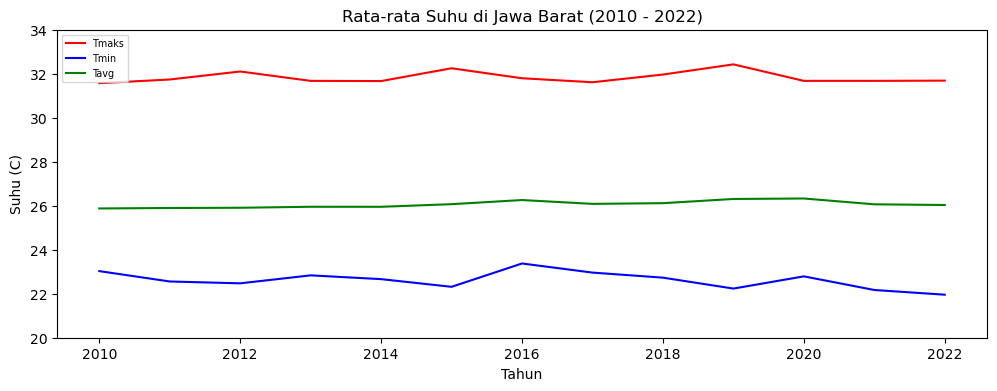

In [115]:
# Select relevant columns

data_tahunan_sorted .filter(data_tahunan_sorted['periode'] != 2023)

selected_columns = ["periode", "mean_tmin", "mean_tmaks", "mean_tavg"]
df_selected = data_tahunan_sorted.select(selected_columns)

# Convert PySpark DataFrame to Pandas DataFrame
df_pandas = df_selected.toPandas()

# Plot the data using Matplotlib
plt.figure(figsize=(12, 4))
plt.plot(df_pandas["periode"], df_pandas ["mean_tmaks"], label="Tmaks", color = "red", alpha=1)
plt.plot(df_pandas["periode"], df_pandas ["mean_tmin"], label="Tmin", color="blue", alpha=1)
plt.plot(df_pandas["periode"], df_pandas ["mean_tavg"], label="Tavg", color="green", alpha=1)
plt.xticks(range(2010, 2023, 2))
plt.yticks(range(20, 35, 2))


# Add a title and labels to the axes
plt.title("Rata-rata Suhu di Jawa Barat (2010 - 2022)")
plt.xlabel("Tahun")
plt.ylabel("Suhu (C)")

# Add a legend
plt.legend(loc="upper left", fontsize="x-small")

# Show the plot
plt.show()


##### Berdasarkan grafik ini, dapat disimpulkan bahwa suhu rata-rata di Jawa Barat secara umum meningkat selama periode tersebut. Pada tahun 2000, suhu rata-rata di Jawa Barat adalah sekitar 32°C. Suhu rata-rata ini meningkat menjadi sekitar 34°C pada tahun 2022.

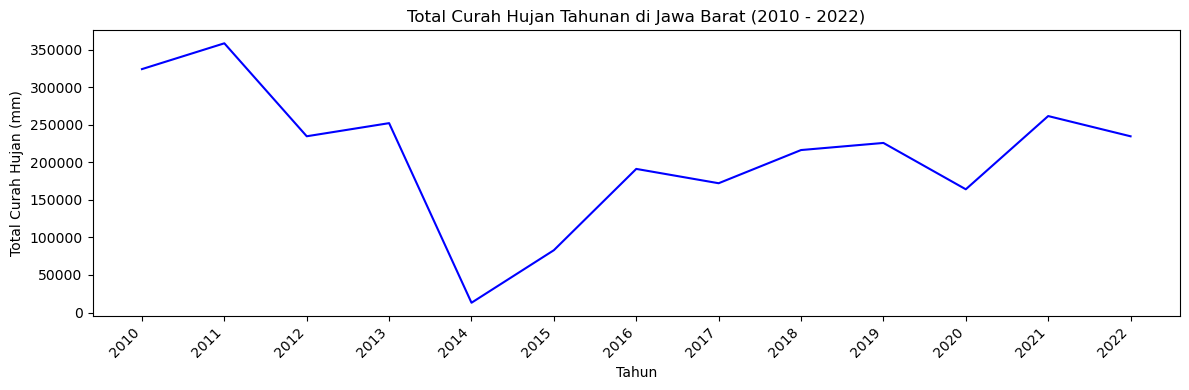

In [116]:
# Convert PySpark DataFrame to Pandas DataFrame
data_tahunan_pandas = data_tahunan_sorted.select(
    "periode",
    "total_curah_hujan"
).toPandas()

# Plot the data using Matplotlib
plt.figure(figsize=(12, 4))
plt.plot(data_tahunan_pandas["periode"], data_tahunan_pandas["total_curah_hujan"], color="blue", alpha=1)
plt.xticks(data_tahunan_pandas["periode"], rotation=45, ha="right")

# Add a title and labels to the axes
plt.title("Total Curah Hujan Tahunan di Jawa Barat (2010 - 2022)")
plt.xlabel("Tahun")
plt.ylabel("Total Curah Hujan (mm)")

# Show the plot
plt.tight_layout()
plt.show()


#### Berdasarkan grafik di atas, curah hujan tahunan di Jawa Barat cenderung meningkat dari tahun ke tahun. Pada tahun 2010, total curah hujan tahunan di Jawa Barat adalah sekitar 324ribu milimeter. Jumlah ini mengalami penurunan sekitar 28% di tahun 2022.

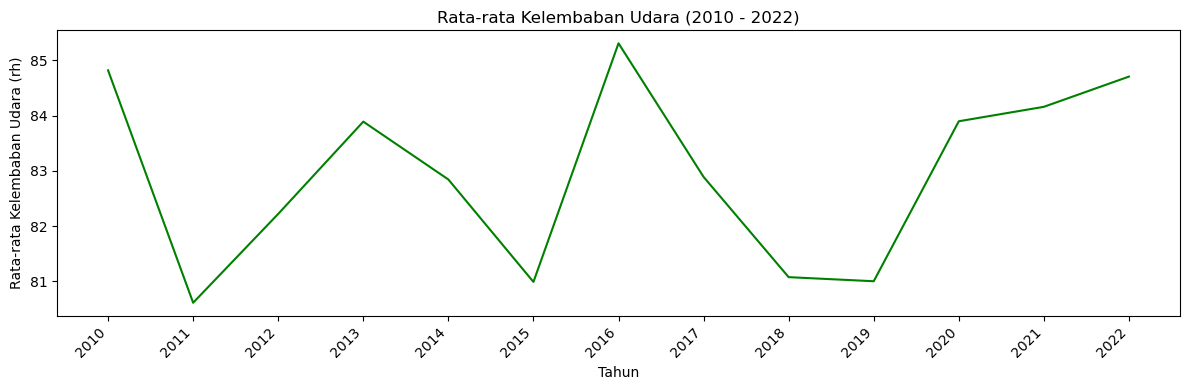

In [117]:
# Convert PySpark DataFrame to Pandas DataFrame
data_tahunan_pandas = data_tahunan_sorted.select(
    "periode",
    "mean_kelembaban"
).toPandas()

# Plot the data using Matplotlib
plt.figure(figsize=(12, 4))
plt.plot(data_tahunan_pandas["periode"], data_tahunan_pandas["mean_kelembaban"], color="green", alpha=1)
plt.xticks(data_tahunan_pandas["periode"], rotation=45, ha="right")

# Add a title and labels to the axes
plt.title("Rata-rata Kelembaban Udara (2010 - 2022)")
plt.xlabel("Tahun")
plt.ylabel("Rata-rata Kelembaban Udara (rh)")

# Show the plot
plt.tight_layout()
plt.show()

In [118]:
import pyspark.sql.functions as F

# Load data
cuaca_data = data_tahunan_formatted


# Split the data into two tables
cuaca_data_tahunan = cuaca_data.select("periode", "mean_tmin", "mean_tmaks", "mean_tavg", "total_curah_hujan", "mean_kelembaban")
#cuaca_data_periode = cuaca_data.select("periode")

# Save the normalized data
cuaca_data_tahunan.write.csv("data/cuaca_tahunan.csv", header=True)
#cuaca_data_periode.write.csv("data/cuaca_periode_norm.csv", header=True)


AnalysisException: [PATH_ALREADY_EXISTS] Path file:/C:/Users/Nadya Arassy/Downloads/ds_dataset/data/cuaca_tahunan.csv already exists. Set mode as "overwrite" to overwrite the existing path.

In [ ]:
cuaca_data_tahunan.show()

In [ ]:
# Hitung korelasi antara suhu harian dan kelembaban harian
correlation_year = cuaca_data_tahunan.agg(F.corr("mean_tavg", "mean_kelembaban")).collect()[0][0]
print("Korelasi antara temperatur rata-rata tahunan  dan kelembaban udara selama periode 2010 - 2022:", correlation_year)

In [ ]:
# Korelasi antara mean_kelembaban dengan total_curah_hujan
correlation_kelembaban_curah_hujan = df.select(col("mean_kelembaban").cast("double"), col("total_curah_hujan").cast("double")).corr("mean_kelembaban", "total_curah_hujan")
print("Korelasi antara mean_kelembaban dan total_curah_hujan:", correlation_kelembaban_curah_hujan)



In [ ]:
# Korelasi antara total_curah_hujan dengan mean_tavg
correlation_curah_hujan_tavg = df.select(col("total_curah_hujan").cast("double"), col("mean_tavg").cast("double")).corr("total_curah_hujan", "mean_tavg")
print("Korelasi antara total_curah_hujan dan mean_tavg:", correlation_curah_hujan_tavg)


#### Scetter Plot Curah Hujan Vs. Kelembaban Udara

In [ ]:
# Scatter plot curah hujan vs. kelembaban udara

# Continue with your scatter plot code or any other operations
selected_columns = ['total_curah_hujan', 'mean_kelembaban']
df_selected = data_tahunan_sorted.select(selected_columns)

# Convert PySpark DataFrame to Pandas DataFrame
df_pandas = df_selected.toPandas()
plt.scatter(df_pandas['total_curah_hujan'], df_pandas['mean_kelembaban'])
plt.xlabel('Curah Hujan (mm)')
plt.ylabel('Kelembaban Udara (rh)')
plt.title('Scatter Plot Tahunan Curah Hujan Vs. Kelembaban Udara')
plt.show()



#### Mengolah Data Produksi Padi

In [ ]:
produksi_padi = pd.read_csv("produksi_padi.csv")
print(produksi_padi)

In [ ]:
produksi_padi_df.printSchema()

In [119]:
# Assuming 'scaled_data' is your PySpark DataFrame
cols_to_cast = ['Provinsi Jawa Barat', 'Bogor', 'Sukabumi', 'Cianjur','Bandung', 'Garut', 'Tasikmalaya', 'Ciamis', 'Kuningan', 'Cirebon','Majalengka', 'Sumedang', 'Indramayu', 'Subang', 'Purwakarta', 'Karawang', 'Bekasi', 'Bandung Barat', 'Pangandaran', 'Kota Bogor',
       'Kota Sukabumi', 'Kota Bandung', 'Kota Cirebon', 'Kota Bekasi',
       'Kota Depok', 'Kota Cimahi', 'Kota Tasikmalaya', 'Kota Banjar']

# Loop through the columns and cast them to float
for col_name in cols_to_cast:
    produksi_padi_df = produksi_padi_df.withColumn(col_name, col(col_name).cast("float"))

# Show the schema after changing the data types
produksi_padi_df.printSchema()

# Show the final result
produksi_padi_df.show(10)


root
 |-- periode: integer (nullable = true)
 |-- Provinsi Jawa Barat: float (nullable = true)
 |-- Bogor: float (nullable = true)
 |-- Sukabumi: float (nullable = true)
 |-- Cianjur: float (nullable = true)
 |-- Bandung: float (nullable = true)
 |-- Garut: float (nullable = true)
 |-- Tasikmalaya: float (nullable = true)
 |-- Ciamis: float (nullable = true)
 |-- Kuningan: float (nullable = true)
 |-- Cirebon: float (nullable = true)
 |-- Majalengka: float (nullable = true)
 |-- Sumedang: float (nullable = true)
 |-- Indramayu: float (nullable = true)
 |-- Subang: float (nullable = true)
 |-- Purwakarta: float (nullable = true)
 |-- Karawang: float (nullable = true)
 |-- Bekasi: float (nullable = true)
 |-- Bandung Barat: float (nullable = true)
 |-- Pangandaran: float (nullable = true)
 |-- Kota Bogor: float (nullable = true)
 |-- Kota Sukabumi: float (nullable = true)
 |-- Kota Bandung: float (nullable = true)
 |-- Kota Cirebon: float (nullable = true)
 |-- Kota Bekasi: float (nullab

In [120]:
# Load DataFrame cuaca_data
cuaca_data = cuaca_data_tahunan

# Load DataFrame produksi_padi
produksi_padi = produksi_padi_df

# Pilih kolom-kolom yang diperlukan dari masing-masing DataFrame
cuaca_data_selected = cuaca_data.select("periode", "mean_tmin", "mean_tmaks", "mean_tavg", "total_curah_hujan", "mean_kelembaban")
produksi_padi_selected = produksi_padi.select("periode", "Provinsi Jawa Barat", "Bogor", "Sukabumi", "Cianjur",
                                             "Bandung", "Garut", "Tasikmalaya", "Ciamis", "Kuningan", 
                                             "Cirebon", "Majalengka", "Sumedang", "Indramayu", "Subang",
                                             "Purwakarta", "Karawang", "Bekasi", "Bandung Barat", "Pangandaran",
                                             "Kota Bogor", "Kota Sukabumi", "Kota Bandung", "Kota Cirebon",
                                             "Kota Bekasi", "Kota Depok", "Kota Cimahi", "Kota Tasikmalaya",
                                             "Kota Banjar")

# Tampilkan hasil
data_tahunan_formatted.show(25)

# Gabungkan DataFrame berdasarkan kolom "periode"
joined_data = cuaca_data_selected.join(produksi_padi_selected, "periode", "inner")

# Hitung korelasi antara kolom-kolom numerik

#correlation_matrix = joined_data.select(
 #   [col(c).cast("double") for c in joined_data.columns if c != "periode"]
#).toPandas().corr()

# Tampilkan matriks korelasi
#print(correlation_matrix)
# Tampilkan hasil gabungan
joined_data.show(10)


+-------+---------+----------+---------+-----------------+---------------+
|periode|mean_tmin|mean_tmaks|mean_tavg|total_curah_hujan|mean_kelembaban|
+-------+---------+----------+---------+-----------------+---------------+
|   2010|    23.03|     31.57|    25.88|       324,018.80|          84.82|
|   2011|    22.56|     31.74|    25.90|       358,362.10|          80.61|
|   2012|    22.47|     32.10|    25.91|       234,638.70|          82.22|
|   2013|    22.83|     31.67|    25.95|       252,102.20|          83.89|
|   2014|    22.66|     31.67|    25.95|        13,063.50|          82.84|
|   2015|    22.31|     32.25|    26.07|        83,005.90|          80.99|
|   2016|    23.37|     31.79|    26.26|       191,190.30|          85.31|
|   2017|    22.96|     31.61|    26.08|       172,127.10|          82.89|
|   2018|    22.73|     31.96|    26.12|       216,294.80|          81.08|
|   2019|    22.23|     32.42|    26.31|       225,755.90|          81.00|
|   2020|    22.79|     3

In [121]:
#Display data with pandas format
joined_data.toPandas().head()

,periode,mean_tmin,mean_tmaks,mean_tavg,total_curah_hujan,mean_kelembaban,Provinsi Jawa Barat,Bogor,Sukabumi,Cianjur,...,Pangandaran,Kota Bogor,Kota Sukabumi,Kota Bandung,Kota Cirebon,Kota Bekasi,Kota Depok,Kota Cimahi,Kota Tasikmalaya,Kota Banjar
0,2018,22.73,31.96,26.12,"216,294.80",81.08,9647359.0,348683.59375,525859.00000,696726.0,...,194398.093750,420.380005,14436.500000,8244.509766,1767.920044,2459.629883,357.059998,393.820007,46943.050781,31610.429688
1,2015,22.31,32.25,26.07,"83,005.90",80.99,11373143.0,492207.00000,842655.00000,851650.0,...,166428.000000,3588.000000,24474.000000,10672.000000,2425.000000,3050.000000,1475.000000,2240.000000,65829.000000,38412.000000
2,2022,21.96,31.69,26.03,"234,593.90",84.71,9433723.0,299893.81250,508220.46875,617941.0,...,148670.609375,173.990005,13254.339844,7186.109863,861.820007,1868.439941,72.129997,338.029999,54233.660156,31271.179688
3,2013,22.83,31.67,25.95,"252,102.20",83.89,12083162.0,559367.00000,767668.00000,882662.0,...,NaN,3585.000000,21721.000000,13654.000000,2384.000000,3926.000000,1880.000000,2846.000000,78975.000000,41124.000000
4,2014,22.66,31.67,25.95,"13,063.50",82.84,11644899.0,517442.00000,897485.00000,830545.0,...,157035.000000,2516.000000,21971.000000,9729.000000,2271.000000,3522.000000,2031.000000,3353.000000,66423.000000,35519.000000


In [122]:
import pyspark.sql.functions as F

# Load data
data_fix = joined_data


# Split the data into two tables
data_fix = joined_data.select("periode", "mean_tmin", "mean_tmaks", "mean_tavg", "total_curah_hujan", "mean_kelembaban", "Provinsi Jawa Barat", "Bogor", "Sukabumi", "Cianjur",
                                             "Bandung", "Garut", "Tasikmalaya", "Ciamis", "Kuningan", 
                                             "Cirebon", "Majalengka", "Sumedang", "Indramayu", "Subang",
                                             "Purwakarta", "Karawang", "Bekasi", "Bandung Barat", "Pangandaran",
                                             "Kota Bogor", "Kota Sukabumi", "Kota Bandung", "Kota Cirebon",
                                             "Kota Bekasi", "Kota Depok", "Kota Cimahi", "Kota Tasikmalaya",
                                             "Kota Banjar")
#cuaca_data_periode = cuaca_data.select("periode")

# Save the normalized data
data_fix.write.csv("data/data_fix2.csv", header=True)
#cuaca_data_periode.write.csv("data/cuaca_periode_norm.csv", header=True)


AnalysisException: [PATH_ALREADY_EXISTS] Path file:/C:/Users/Nadya Arassy/Downloads/ds_dataset/data/data_fix2.csv already exists. Set mode as "overwrite" to overwrite the existing path.

In [123]:
#Display data with pandas format
data_fix.toPandas().head()

,periode,mean_tmin,mean_tmaks,mean_tavg,total_curah_hujan,mean_kelembaban,Provinsi Jawa Barat,Bogor,Sukabumi,Cianjur,...,Pangandaran,Kota Bogor,Kota Sukabumi,Kota Bandung,Kota Cirebon,Kota Bekasi,Kota Depok,Kota Cimahi,Kota Tasikmalaya,Kota Banjar
0,2018,22.73,31.96,26.12,"216,294.80",81.08,9647359.0,348683.59375,525859.00000,696726.0,...,194398.093750,420.380005,14436.500000,8244.509766,1767.920044,2459.629883,357.059998,393.820007,46943.050781,31610.429688
1,2015,22.31,32.25,26.07,"83,005.90",80.99,11373143.0,492207.00000,842655.00000,851650.0,...,166428.000000,3588.000000,24474.000000,10672.000000,2425.000000,3050.000000,1475.000000,2240.000000,65829.000000,38412.000000
2,2022,21.96,31.69,26.03,"234,593.90",84.71,9433723.0,299893.81250,508220.46875,617941.0,...,148670.609375,173.990005,13254.339844,7186.109863,861.820007,1868.439941,72.129997,338.029999,54233.660156,31271.179688
3,2013,22.83,31.67,25.95,"252,102.20",83.89,12083162.0,559367.00000,767668.00000,882662.0,...,NaN,3585.000000,21721.000000,13654.000000,2384.000000,3926.000000,1880.000000,2846.000000,78975.000000,41124.000000
4,2014,22.66,31.67,25.95,"13,063.50",82.84,11644899.0,517442.00000,897485.00000,830545.0,...,157035.000000,2516.000000,21971.000000,9729.000000,2271.000000,3522.000000,2031.000000,3353.000000,66423.000000,35519.000000


## Analisis

In [138]:
data_fix.printSchema()

root
 |-- periode: integer (nullable = true)
 |-- mean_tmin: string (nullable = true)
 |-- mean_tmaks: string (nullable = true)
 |-- mean_tavg: string (nullable = true)
 |-- total_curah_hujan: string (nullable = true)
 |-- mean_kelembaban: string (nullable = true)
 |-- Provinsi Jawa Barat: float (nullable = true)
 |-- Bogor: float (nullable = true)
 |-- Sukabumi: float (nullable = true)
 |-- Cianjur: float (nullable = true)
 |-- Bandung: float (nullable = true)
 |-- Garut: float (nullable = true)
 |-- Tasikmalaya: float (nullable = true)
 |-- Ciamis: float (nullable = true)
 |-- Kuningan: float (nullable = true)
 |-- Cirebon: float (nullable = true)
 |-- Majalengka: float (nullable = true)
 |-- Sumedang: float (nullable = true)
 |-- Indramayu: float (nullable = true)
 |-- Subang: float (nullable = true)
 |-- Purwakarta: float (nullable = true)
 |-- Karawang: float (nullable = true)
 |-- Bekasi: float (nullable = true)
 |-- Bandung Barat: float (nullable = true)
 |-- Pangandaran: float 

In [143]:
columns_to_cast = ['mean_tmin', 'mean_tmaks', 'mean_tavg', 'total_curah_hujan', 'mean_kelembaban', 'Provinsi Jawa Barat']
for column in columns_to_cast:
    data_fix = data_fix.withColumn(column, col(column).cast('float'))

# Calculate correlation matrix
correlation_matrix = data_fix.select(columns_to_cast).toPandas().corr()

# Print the correlation matrix
print("Matrix Korelasi:")
print(correlation_matrix)

# Print the correlation between 'mean_tmin' and 'Provinsi Jawa Barat'
correlation_tmin_jabar = data_fix.select(['mean_tmin', 'Provinsi Jawa Barat']).toPandas().corr().iloc[0, 1]
print("\nKorelasi antara mean_tmin dan Provinsi Jawa Barat:", correlation_tmin_jabar)

correlation_tmaks_jabar = data_fix.select(['mean_tmaks', 'Provinsi Jawa Barat']).toPandas().corr().iloc[0, 1]
print("\nKorelasi antara mean_tmaks dan Provinsi Jawa Barat:", correlation_tmaks_jabar)

correlation_tavg_jabar = data_fix.select(['mean_tavg', 'Provinsi Jawa Barat']).toPandas().corr().iloc[0, 1]
print("\nKorelasi antara mean_tavg dan Provinsi Jawa Barat:", correlation_tavg_jabar)

correlation_tch_jabar = data_fix.select(['total_curah_hujan', 'Provinsi Jawa Barat']).toPandas().corr().iloc[0, 1]
print("\nKorelasi antara total_curah_hujan dan Provinsi Jawa Barat:", correlation_tch_jabar)

correlation_ku_jabar = data_fix.select(['mean_kelembaban', 'Provinsi Jawa Barat']).toPandas().corr().iloc[0, 1]
print("\nKorelasi antara mean_tmin dan Provinsi Jawa Barat:", correlation_ku_jabar)

Matrix Korelasi:
                     mean_tmin  mean_tmaks  mean_tavg  total_curah_hujan  \
mean_tmin             1.000000   -0.397036   0.081737                NaN   
mean_tmaks           -0.397036    1.000000   0.331322                NaN   
mean_tavg             0.081737    0.331322   1.000000                NaN   
total_curah_hujan          NaN         NaN        NaN                NaN   
mean_kelembaban       0.332356   -0.658567   0.036388                NaN   
Provinsi Jawa Barat   0.645406   -0.259107  -0.466121                NaN   

                     mean_kelembaban  Provinsi Jawa Barat  
mean_tmin                   0.332356             0.645406  
mean_tmaks                 -0.658567            -0.259107  
mean_tavg                   0.036388            -0.466121  
total_curah_hujan                NaN                  NaN  
mean_kelembaban             1.000000             0.105634  
Provinsi Jawa Barat         0.105634             1.000000  

Korelasi antara mean_tmin dan

Coefficients: [2532466.4754919773,174576.06900216202]
Intercept: -51916024.49338902
+---------+----------+-------------------+--------------------+
|mean_tmin|mean_tmaks|Provinsi Jawa Barat|          prediction|
+---------+----------+-------------------+--------------------+
|    22.47|      32.1|        1.1271861E7|1.0592387020596437E7|
|    23.37|     31.79|         1.254055E7|1.2817492557596833E7|
|    22.73|     31.96|          9647359.0|1.1226388340752408E7|
+---------+----------+-------------------+--------------------+



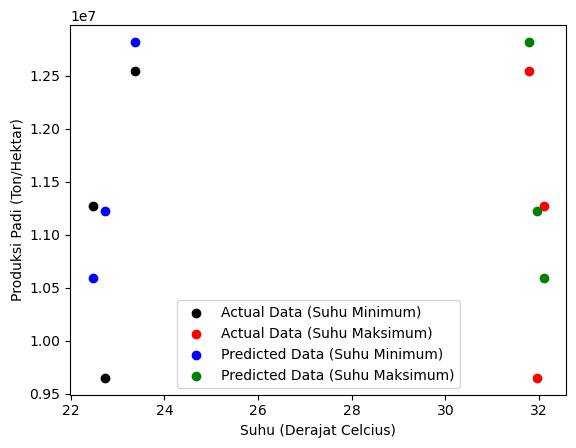

In [148]:
# Split the data into training and testing sets
(training_data, testing_data) = data_fix.randomSplit([0.8, 0.2], seed=42)

# Initialize the Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='Provinsi Jawa Barat')

# Fit the model on the training data
lr_model = lr.fit(training_data)

# Make predictions on the test data
predictions = lr_model.transform(testing_data)

# Show the coefficients and intercept
print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)

# Visualize the results
predictions.select("mean_tmin", "mean_tmaks", "Provinsi Jawa Barat", "prediction").show()

# Plot the actual vs predicted values
plt.scatter(predictions.select("mean_tmin").collect(), predictions.select("Provinsi Jawa Barat").collect(), color='black', label='Actual Data (Suhu Minimum)')
plt.scatter(predictions.select("mean_tmaks").collect(), predictions.select("Provinsi Jawa Barat").collect(), color='red', label='Actual Data (Suhu Maksimum)')
plt.scatter(predictions.select("mean_tmin").collect(), predictions.select("prediction").collect(), color='blue', label='Predicted Data (Suhu Minimum)')
plt.scatter(predictions.select("mean_tmaks").collect(), predictions.select("prediction").collect(), color='green', label='Predicted Data (Suhu Maksimum)')
plt.xlabel("Suhu (Derajat Celcius)")
plt.ylabel("Produksi Padi (Ton/Hektar)")
plt.legend()
plt.show()
